In [1]:
!date

Thu Oct  3 18:46:37 EDT 2024


In [2]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-denoise/Code'

In [3]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel.processing as nibp
from scipy import signal
from itertools import combinations_with_replacement
from numpy import savetxt
import nibabel as nib
import math
from numpy import random
import sklearn.preprocessing  
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from typing import List, Callable, Union, Any, TypeVar, Tuple
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn import linear_model

In [4]:
import ants
from tqdm import tqdm
import seaborn as sns

/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
def correlation(x,y):
  x_mean = np.repeat(x.mean(),x.shape,axis=0)
  y_mean = np.repeat(y.mean(),y.shape,axis=0)
  cov = (x-x_mean)*(y-y_mean)
  r = cov.sum()/(x.std()*y.std()*x.shape[0])
  return r

def remove_std0(arr):
    std0 = np.argwhere(np.std(arr, axis=1) == 0.0)
    arr_o = np.delete(arr,std0 ,axis=0) 
    return arr_o

def compute_in(x):
  return (x-3)/2+1

def compute_in_size(x):
  for i in range(4):
    x = compute_in(x)
  return x

def compute_out_size(x):
  return ((((x*2+1)*2+1)*2+1)*2+1)

def compute_padding(x):
  rounding = np.ceil(compute_in_size(x))-compute_in_size(x)
  y = ((((rounding*2)*2)*2)*2)
  pad = bin(int(y)).replace('0b', '')
  if len(pad) < 4:
      for i in range(4-len(pad)):
          pad = '0' + pad
  final_size = compute_in_size(x+y)
  pad_out = bin(int(compute_out_size(final_size)-x)).replace('0b','')
  if len(pad_out) < 4:
      for i in range(4-len(pad_out)):
          pad_out = '0' + pad_out
  return pad,final_size, pad_out

In [6]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

# Example usage:
#ARR1 = np.random.rand(370, 1000)  # Replace with your actual matrix
#ARR2 = np.random.rand(370, 1000)  # Replace with your actual matrix
#correlations = correlate_columns(ARR1, ARR2)


def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    from scipy.spatial.distance import pdist
    from scipy.spatial.distance import squareform
    vec = inVec
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten()))
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose()
                   
    mat = squareform(pdist(vec,metric=metric).transpose())
    if data_scale=='ordinal':
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):
    assert np.ndim(inMat)==2, 'not 2 dim, wtf'
    assert inMat.shape[0]==inMat.shape[1], 'not a square'

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)]
    return triu_vec

In [7]:
class Scaler():
    def __init__(self,inputs):
        self.data = inputs
        self.mean = np.mean(inputs,axis=1)
        self.std = np.std(inputs, axis=1)
        self.vox, self.time = inputs.shape
    def transform(self,inputs):
        self.mean = np.reshape(self.mean,(self.vox,1))
        self.m_large = np.repeat(self.mean,self.time,axis=1)
        self.std = np.reshape(self.std,(self.vox,1))
        self.s_large = np.repeat(self.std,self.time,axis=1)
        return np.divide(inputs-self.m_large,self.s_large)
    def inverse_transform(self,outputs):
        return np.multiply(outputs,self.s_large)+self.m_large


In [8]:
class TrainDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.obs = X
    self.noi = Y

  def __len__(self):
    return min(self.obs.shape[0],self.noi.shape[0])

  def __getitem__(self, index):
    observation = self.obs[index]
    noise = self.noi[index]
    s = 2*random.beta(4,4,1)
    noise_aug = s*noise
    return observation, noise_aug
    #return observation, noise

class DenoiseDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X):
    self.obs = X
    
  def __len__(self):
    return self.obs.shape[0]

  def __getitem__(self, index):
    observation = self.obs[index]
    return observation



In [9]:
# Define a shallow classifier (1-neuron network)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(input_dim, 1)  # 1-neuron output layer
    
    def forward(self, x):
        return torch.sigmoid(self.fc(x))  # Apply sigmoid to get a probability between 0 and 1

In [10]:
class cVAE(nn.Module):

    def __init__(self,in_channels: int,in_dim: int, latent_dim: int,hidden_dims: List = None) -> None:
        super(cVAE, self).__init__()

        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.in_dim = in_dim

        modules_z = []
        if hidden_dims is None:
            hidden_dims = [64, 128, 256, 256]
        
        self.pad, self.final_size, self.pad_out = compute_padding(self.in_dim)

        # Build Encoder
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_z.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_z = nn.Sequential(*modules_z)
        self.fc_mu_z = nn.Linear(hidden_dims[-1]*int(self.final_size), latent_dim)
        self.fc_var_z = nn.Linear(hidden_dims[-1]*int(self.final_size), latent_dim)

        modules_s = []
        in_channels = self.in_channels
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_s.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_s = nn.Sequential(*modules_s)
        self.fc_mu_s = nn.Linear(hidden_dims[-1]*int(self.final_size), latent_dim)
        self.fc_var_s = nn.Linear(hidden_dims[-1]*int(self.final_size), latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * int(self.final_size))

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose1d(hidden_dims[i],
                                    hidden_dims[i + 1],
                                    kernel_size=3,
                                    stride = 2,
                                    padding=int(self.pad_out[-4+i]),
                                    output_padding=int(self.pad_out[-4+i])),
                    nn.BatchNorm1d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )


        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=int(self.pad_out[-1]),
                                               output_padding=int(self.pad_out[-1])),
                            nn.BatchNorm1d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv1d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1))
           #out_channels

    def encode_z(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_z(input)
  
        result = torch.flatten(result, start_dim=1)


        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_z(result)
        log_var = self.fc_var_z(result)

        return [mu, log_var]

    def encode_s(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_s(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_s(result)
        log_var = self.fc_var_s(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1,256,int(self.final_size))
        result = self.decoder(result)
        result = self.final_layer(result)

        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward_tg(self, input: Tensor) -> List[Tensor]:
        tg_mu_z, tg_log_var_z = self.encode_z(input)
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        output = self.decode(torch.cat((tg_z, tg_s),1))
        return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

    def forward_bg(self, input: Tensor) -> List[Tensor]:
        bg_mu_s, bg_log_var_s = self.encode_s(input)
        bg_s = self.reparameterize(bg_mu_s, bg_log_var_s)
        zeros = torch.zeros_like(bg_s)
        output = self.decode(torch.cat((zeros, bg_s),1))
        return  [output, input, bg_mu_s, bg_log_var_s]

    def forward_fg(self, input: Tensor) -> List[Tensor]:
        fg_mu_z, fg_log_var_z = self.encode_z(input)
        tg_z = self.reparameterize(fg_mu_z, fg_log_var_z)
        zeros = torch.zeros_like(tg_z)
        output = self.decode(torch.cat((tg_z, zeros),1))
        return  [output, input, fg_mu_z, fg_log_var_z]

    def loss_function(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        beta = 0.00001
        #beta = 0.01
        gamma = 0

        recons_tg = args[0]
        input_tg = args[1]
        tg_mu_z = args[2]
        tg_log_var_z = args[3]
        tg_mu_s = args[4]
        tg_log_var_s = args[5]
        tg_z = args[6]
        tg_s = args[7]
        recons_bg = args[8]
        input_bg = args[9]
        bg_mu_s = args[10]
        bg_log_var_s = args[11]

        #kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss_roi = F.mse_loss(recons_tg, input_tg)
        recons_loss_roni = F.mse_loss(recons_bg, input_bg)
        recons_loss = recons_loss_roi+recons_loss_roni
        #recons_loss = F.mse_loss(recons_tg, input_tg)
        #recons_loss += F.mse_loss(recons_bg, input_bg)
        # recons_loss *= input_shape[0]*input_shape[1]

        # z1 = tg_z[:int(batch_size/2),:]
        # z2 = tg_z[int(batch_size/2):,:]
        # s1 = tg_s[:int(batch_size/2),:]
        # s2 = tg_s[int(batch_size/2):,:]
        # q_bar = torch.cat(torch.cat((s1,z2),1),torch.cat((s2,z1),1),0)
        # q = torch.cat(torch.cat((s1,z1),1),torch.cat((s2,z1),1),0)
        # q_bar_score = nn.Sigmoid(q_bar)
        # q_score = nn.Sigmoid(q)
        # tc_loss = torch.log(q_score/(1-q_score))
        # discriminator_loss = - torch.log(q_score) - torch.log(1-q_bar_score)


        do_disentangle=True
        if do_disentangle==True:
            # Split the latent variables into two groups
            z1 = tg_z[:int(batch_size/2), :]  # First half of z
            z2 = tg_z[int(batch_size/2):, :]  # Second half of z
            s1 = tg_s[:int(batch_size/2), :]  # First half of s
            s2 = tg_s[int(batch_size/2):, :]  # Second half of s
    
            # print(f'tg_z.shape {tg_z.shape}')
            # print(f'tg_s.shape {tg_s.shape}')
            # print(f'z1.shape {z1.shape}')
            # print(f'z2.shape {z2.shape}')
            # print(f's1.shape {s1.shape}')
            # print(f's2.shape {s2.shape}')
                              
            # # Construct "positive" and "negative" samples for contrastive learning
            # q = torch.cat((s1, z1), dim=1)  # Positive pairs (s1, z1)
            # q_bar = torch.cat((s1, z2), dim=1)  # Negative pairs (s1, z2)
    
            # Construct "positive" pairs
            q1 = torch.cat((s1, z1), dim=1)  # Positive pairs from first half (s1, z1)
            q2 = torch.cat((s2, z2), dim=1)  # Positive pairs from second half (s2, z2)
            q = torch.cat((q1, q2), dim=0)   # Combine the two sets of positive pairs
    
            # Construct "negative" pairs by misaligning the latent variables
            q_bar1 = torch.cat((s1, z2), dim=1)  # Negative pairs from mismatched (s1, z2)
            q_bar2 = torch.cat((s2, z1), dim=1)  # Negative pairs from mismatched (s2, z1)
            q_bar = torch.cat((q_bar1, q_bar2), dim=0)  # Combine the two sets of negative pairs
    
            # # Compute the scores
            #q_score = torch.sigmoid(q)  # Positive score
            #q_bar_score = torch.sigmoid(q_bar)  # Negative score

            ## NEW WAY
            #input_dim = tg_z.size(1) + tg_s.size(1)  # The input is the concatenated latent dimensions of s and z
            #print(input_dim)
            #discriminator = Discriminator(input_dim)
            q_score = discriminator(q)  # Positive pair scores
            q_bar_score = discriminator(q_bar)  # Negative pair scores
    
            # Implement the density-ratio trick
            # tc_loss = log(P(positive) / P(negative))
            tc_loss = torch.mean(torch.log(q_score / (1 - q_score)))  # Density ratio loss
    
            # Discriminator loss: encourage correct classification of positive and negative pairs
            discriminator_loss = -torch.mean(torch.log(q_score) + torch.log(1 - q_bar_score))
    
            # Total loss would combine these losses (tc_loss + discriminator_loss can be weighted)
            total_contrastive_loss = tc_loss + discriminator_loss



        kld_loss = 1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp()
        kld_loss += 1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp()
        kld_loss += 1 + bg_log_var_s - bg_mu_s ** 2 - bg_log_var_s.exp()
        kld_loss = torch.mean(-0.5 * torch.sum(kld_loss, dim = 1), dim = 0)

        if do_disentangle==True:
            loss = torch.sum(recons_loss + beta*kld_loss + gamma*total_contrastive_loss + recons_loss_roi + recons_loss_roni)
            return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD': kld_loss.detach()*beta, 'total_contrastive_loss' : total_contrastive_loss.detach()*gamma, 'recons_loss_roni' : recons_loss_roni.detach(), 'recons_loss_roi' : recons_loss_roi.detach()}
        else:
            loss = torch.sum(recons_loss + beta*kld_loss + gamma*total_contrastive_loss)
            return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD': kld_loss.detach()*beta, 'total_contrastive_loss' : total_contrastive_loss.detach()*gamma, 'recons_loss_roni' : recons_loss_roni.detach(), 'recons_loss_roi' : recons_loss_roi.detach()}

    def sample(self,
               num_samples:int,
               current_device: int) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward_fg(x)[0]

In [11]:
indir = '../Data/020-fmriprepped/'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
n_orig = len(subs_orig)
epi_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii')
cf_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_CF.nii')
gm_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_GM.nii')

subs = [sub for sub in subs_orig if all(( 
    os.path.exists(epi_fn.format(sub=sub,r=1)),
    os.path.exists(epi_fn.format(sub=sub,r=2)),
    os.path.exists(cf_fn.format(sub=sub)),
    os.path.exists(gm_fn.format(sub=sub)),
    ))]

subs.sort()
print(f'{len(subs)}/{len(subs_orig)}')

34/34


In [12]:
s = 0
r = 1

In [13]:
s = int(s)
r = int(r)

sub = subs[s]
print(sub)

epi = ants.image_read(epi_fn.format(sub=sub,r=r))
gm = ants.image_read(gm_fn.format(sub=sub))
cf = ants.image_read(cf_fn.format(sub=sub))

nt = epi.shape[-1] # Number of timepoints
ndummy = 8 # how many dummies to discard

epi_flat = epi.numpy().reshape(-1,nt).transpose() # (370, 1082035)
epi_flat[0:ndummy,:] = epi_flat[ndummy+1::,:].mean(axis=0) # What to do with dummy scans, set to mean
epi_flat = epi_flat.transpose()
gm_flat = gm.numpy().flatten().astype(int) # (1082035,)
cf_flat = cf.numpy().flatten().astype(int) # (1082035,)
assert max(np.unique(cf_flat+gm_flat))!=2, 'overlap' # Check for overlap again

sub-NDARINV1H7JEJW1


In [14]:
print(epi_flat.shape)
print(sum(gm_flat==1))
print(sum(cf_flat==1))

(1082035, 370)
183909
45538


In [15]:
func_gm = epi_flat[gm_flat==1,:]
func_cf = epi_flat[cf_flat==1,:]

In [16]:
def generate_correlated_fmri_noise(length, num_voxels, 
                                   phys_noise_level=0.1, 
                                   motion_noise_level=0.1, 
                                   drift_noise_level=0.05, 
                                   low_freq_noise_level=0.02, 
                                   correlation=0.5, 
                                   seed=None):
    """
    Generates correlated fMRI noise for multiple voxels.
    
    Parameters:
    length (int): Length of the time series (e.g., number of time points in the fMRI scan).
    num_voxels (int): Number of voxels (i.e., how many correlated noise vectors you want).
    phys_noise_level (float): Magnitude of physiological noise (e.g., respiratory and cardiac noise).
    motion_noise_level (float): Magnitude of motion-related noise.
    drift_noise_level (float): Magnitude of scanner drift noise (low-frequency drift).
    low_freq_noise_level (float): Magnitude of general low-frequency noise.
    correlation (float): Desired correlation between noise vectors (between 0 and 1).
    seed (int, optional): Random seed for reproducibility.

    Returns:
    np.ndarray: A matrix of shape (num_voxels, length) with correlated noise for each voxel.
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    # Generate uncorrelated noise for each voxel
    noise_matrix = np.zeros((num_voxels, length))

    for i in range(num_voxels):
        # Generate physiological noise
        phys_noise = phys_noise_level * np.sin(np.linspace(0, 10 * np.pi, length)) * np.random.randn(length)
        
        # Generate motion-related noise (random spikes in signal)
        motion_noise = np.zeros(length)
        for _ in range(int(motion_noise_level * 10)):  # Random number of motion artifacts
            idx = np.random.randint(0, length-5)
            motion_noise[idx:idx+5] = np.random.randn(5) * motion_noise_level  # Add small burst of motion artifact
        
        # Generate low-frequency drift (scanner drift or baseline shift)
        drift_noise = drift_noise_level * np.polyval(np.random.randn(2), np.linspace(-1, 1, length))
        
        # General low-frequency noise (slow oscillations)
        low_freq_noise = low_freq_noise_level * np.sin(np.linspace(0, 2 * np.pi, length)) * np.random.randn(length)
        
        # Combine noise components for each voxel
        noise_matrix[i, :] = phys_noise + motion_noise + drift_noise + low_freq_noise
    
    # Create a correlation matrix
    corr_matrix = np.full((num_voxels, num_voxels), correlation) + np.eye(num_voxels) * (1 - correlation)
    
    # Cholesky decomposition to apply the correlation
    cholesky_decomp = np.linalg.cholesky(corr_matrix)
    
    # Apply the correlation structure to the noise matrix
    correlated_noise = np.dot(cholesky_decomp, noise_matrix)
    
    return correlated_noise





from scipy import signal
from scipy.stats import gamma

def spm_hrf(tr, length=32, peak_delay=6, undershoot_delay=16, peak_disp=1, undershoot_disp=1, ratio=6, scale=1.0):
    """
    Generates a hemodynamic response function (HRF) similar to the SPM canonical HRF.

    Parameters:
    tr (float): Repetition time (TR) of the fMRI scan (in seconds).
    length (float): Length of the HRF (in seconds).
    peak_delay (float): Time to the peak of the HRF (in seconds).
    undershoot_delay (float): Time to the undershoot of the HRF (in seconds).
    peak_disp (float): Dispersion of the peak.
    undershoot_disp (float): Dispersion of the undershoot.
    ratio (float): Ratio of the peak to the undershoot.
    scale (float): Scaling factor for the HRF.

    Returns:
    np.ndarray: The HRF vector sampled at intervals of the TR.
    """
    # Time points at which to evaluate the HRF
    t = np.arange(0, length, tr)
    
    # Gamma function for the peak and undershoot
    peak = gamma.pdf(t, peak_delay / peak_disp, scale=peak_disp)
    undershoot = gamma.pdf(t, undershoot_delay / undershoot_disp, scale=undershoot_disp)
    
    # HRF is the sum of the peak and undershoot components
    hrf = peak - undershoot / ratio
    
    # Normalize and scale the HRF
    hrf /= np.max(hrf)
    hrf *= scale
    
    return hrf

def simulate_voxel_response(boxcar, tr, hrf=None):
    """
    Simulates a voxel response to a task by convolving a boxcar task design with an HRF.
    
    Parameters:
    boxcar (np.ndarray): A binary vector (1=task on, 0=task off) representing the task design.
    tr (float): Repetition time (TR) of the fMRI scan (in seconds).
    hrf (np.ndarray, optional): A custom HRF. If None, a default SPM-like HRF will be used.
    
    Returns:
    np.ndarray: The simulated voxel response (BOLD signal).
    """
    # If no HRF is provided, use a default SPM-like HRF
    if hrf is None:
        hrf = spm_hrf(tr)
    
    # Convolve the boxcar with the HRF to generate the voxel response
    response = signal.convolve(boxcar, hrf)[:len(boxcar)]
    
    return response



def get_gt():
    # Example usage:
    tr = .8  # Repetition time of 2 seconds
    duration = 370  # Number of time points
    boxcar = np.zeros(duration)
    #ons = np.random.randint(low=0,high=300)
    ons = np.random.choice([50,150,250])
    boxcar[ons:ons+100] = 1  # Task "on" from time points 10 to 30
    #boxcar[200:250] = 1  # Task "on" again from time points 50 to 70
    
    # Simulate voxel response
    voxel_response = simulate_voxel_response(boxcar, tr)
    return voxel_response


In [17]:
# Example usage:
do_synth_data = True
if do_synth_data==True:
    num_voxels = 10_000
    noise_matrix = generate_correlated_fmri_noise(length=370, num_voxels=num_voxels, 
                                                  phys_noise_level=0.2, motion_noise_level=0.1, 
                                                  drift_noise_level=0.05, correlation=0.5, seed=42)
    
    
    gound_truth = np.array([get_gt()*.1 for _ in range(10_000)])
    
    
    func_cf = noise_matrix
    func_gm = noise_matrix+gound_truth
    
    func_cf = func_cf*240
    func_gm = func_gm*240

In [18]:
print(func_gm.shape)
print(func_cf.shape)

(10000, 370)
(10000, 370)


In [19]:
#Normalization of Data
func_gm = remove_std0(func_gm)
func_cf = remove_std0(func_cf)
print(func_gm.shape)
print(func_cf.shape)

(10000, 370)
(10000, 370)


In [20]:
obs_scale = Scaler(func_gm)
obs_list = obs_scale.transform(func_gm)
print(obs_list.shape)
noi_scale = Scaler(func_cf)
noi_list = noi_scale.transform(func_cf)
print(noi_list.shape)

(10000, 370)
(10000, 370)


(array([1.050000e+02, 3.548000e+03, 3.932700e+04, 2.739470e+05,
        1.291566e+06, 1.640737e+06, 3.783220e+05, 6.701800e+04,
        5.307000e+03, 1.230000e+02]),
 array([-6.12146178, -4.92085716, -3.72025253, -2.51964791, -1.31904329,
        -0.11843867,  1.08216595,  2.28277057,  3.48337519,  4.68397981,
         5.88458443]),
 <BarContainer object of 10 artists>)

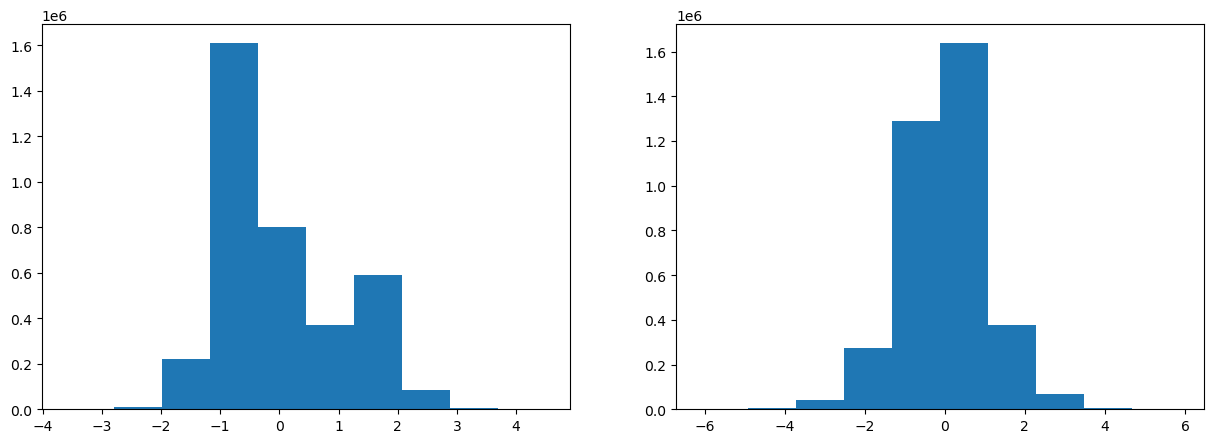

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(obs_list.flatten())

plt.subplot(1,2,2)
plt.hist(noi_list.flatten())

In [22]:
def norm(mat):
    return (mat - mat.min()) / ( mat.max()-mat.min() )

In [23]:
min_obs_list = obs_list.min()
max_obs_list = obs_list.max()

min_noi_list = noi_list.min()
max_noi_list = noi_list.max()

In [24]:
do_norm = False
if do_norm==True:
    obs_list = norm(obs_list)
    noi_list = norm(noi_list)

In [25]:
# DataLoader
train_inputs = TrainDataset(obs_list,noi_list)

# dataloading 
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=64,
                                             shuffle=True, num_workers=1,drop_last=True)

# cVAE model
Tensor = TypeVar('torch.tensor')
latent_dim = 8
model = cVAE(1,func_cf.shape[1],latent_dim)

In [26]:
#inputs_gm,inputs_cf = next(iter(train_in))

In [27]:
#plt.plot(inputs_cf.detach().cpu().numpy()[50,:])

In [28]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# Training the Model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
batch_size = 64
epoch_num = 100
running_loss_L = []
running_recons_L = []
running_recons_roi_L = []
running_recons_roni_L = []
running_KLD_L = []
running_TC_L = []

In [29]:
track = {}
# track['gm_sl+bg'] = []
# track['gm_sl+zeros'] = []
# track['gm_zeros+bg'] = []

# track['cf_sl+bg'] = []
# track['cf_sl+zeros'] = []
# track['cf_zeros+bg'] = []

track['cmat_bg'] = []
track['cmat_cf'] = []

In [30]:
discriminator = Discriminator(latent_dim*2)
discriminator.to(device)

Discriminator(
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [31]:
for epoch in tqdm(range(epoch_num)):  # loop over the dataset multiple times    
    running_loss = 0.0
    running_reconstruction_loss = 0.0
    running_reconstruction_loss_roi = 0.0
    running_reconstruction_loss_roni = 0.0
    running_KLD = 0.0
    running_TC = 0.0

    # Iterate over data.
    dataloader_iter_in = iter(train_in)
    for i in range(len(train_in)):
        inputs_gm,inputs_cf = next(dataloader_iter_in)

        inputs_gm = inputs_gm.unsqueeze(1).float().to(device)
        inputs_cf = inputs_cf.unsqueeze(1).float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # encoder + decoder
        [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(inputs_gm)
        [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(inputs_cf)
        outputs = torch.concat((outputs_gm,outputs_cf),1)
        loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x, outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s)
        # backward + optimize
        loss['loss'].backward()
        optimizer.step()
        running_loss += loss['loss']
        running_reconstruction_loss += loss['Reconstruction_Loss']
        running_reconstruction_loss_roi += loss['recons_loss_roi']
        running_reconstruction_loss_roni += loss['recons_loss_roni']        
        running_KLD += loss['KLD']   
        running_TC += loss['total_contrastive_loss']  

    outputs_gm_tg = model.forward_tg(inputs_gm)[0]
    outputs_gm_fg = model.forward_fg(inputs_gm)[0]
    outputs_gm_bg = model.forward_bg(inputs_gm)[0]
    
    outputs_cf_tg = model.forward_tg(inputs_cf)[0]
    outputs_cf_fg = model.forward_fg(inputs_cf)[0]
    outputs_cf_bg = model.forward_bg(inputs_cf)[0]

    cmat_bg = np.array([(np.corrcoef(np.array((inputs_gm.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_tg.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_fg.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_bg.detach().cpu().numpy()[:,0,:][v,:])))) for v in range(inputs_gm.shape[0])]).mean(axis=0)

    cmat_cf = np.array([(np.corrcoef(np.array((inputs_cf.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_tg.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_fg.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_bg.detach().cpu().numpy()[:,0,:][v,:])))) for v in range(inputs_gm.shape[0])]).mean(axis=0)

    track['cmat_bg'].append(cmat_bg)
    track['cmat_cf'].append(cmat_cf)

    epoch_running_loss = running_loss / (len(train_in)*2)
    epoch_running_reconstruction_loss = running_reconstruction_loss / (len(train_in)*2)
    running_reconstruction_loss_roi = running_reconstruction_loss_roi / (len(train_in)*2)
    running_reconstruction_loss_roni = running_reconstruction_loss_roni / (len(train_in)*2)

    epoch_running_KLD = running_KLD / (len(train_in)*2)
    epoch_running_TC = running_TC / (len(train_in)*2)
    
    running_loss_L.append(epoch_running_loss.cpu().detach().numpy())
    running_recons_L.append(epoch_running_reconstruction_loss.cpu().detach().numpy())
    running_KLD_L.append(epoch_running_KLD.cpu().detach().numpy())
    running_TC_L.append(epoch_running_TC.cpu().detach().numpy())
    running_recons_roi_L.append(running_reconstruction_loss_roi.cpu().detach().numpy())
    running_recons_roni_L.append(running_reconstruction_loss_roni.cpu().detach().numpy())

100%|█████████████████████████████████████████| 100/100 [05:13<00:00,  3.14s/it]


In [32]:
#np.array([np.corrcoef(inputs_gm.detach().cpu().numpy()[:,0,:][v,:],inputs_cf.detach().cpu().numpy()[:,0,:][v,:])[0,1] for v in range(inputs_gm.shape[0])]).mean()

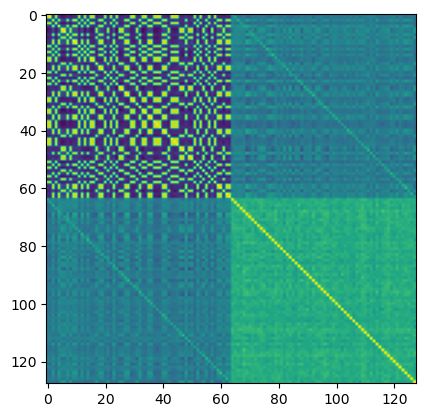

In [33]:
plt.imshow(np.corrcoef(inputs_gm.detach().cpu().numpy()[:,0,:],inputs_cf.detach().cpu().numpy()[:,0,:]))

In [34]:
outputs_gm_tg = model.forward_tg(inputs_gm)[0]
outputs_gm_fg = model.forward_fg(inputs_gm)[0]
outputs_gm_bg = model.forward_bg(inputs_gm)[0]

outputs_cf_tg = model.forward_tg(inputs_cf)[0]
outputs_cf_fg = model.forward_fg(inputs_cf)[0]
outputs_cf_bg = model.forward_bg(inputs_cf)[0]

Text(0.5, 1.0, 'RONI')

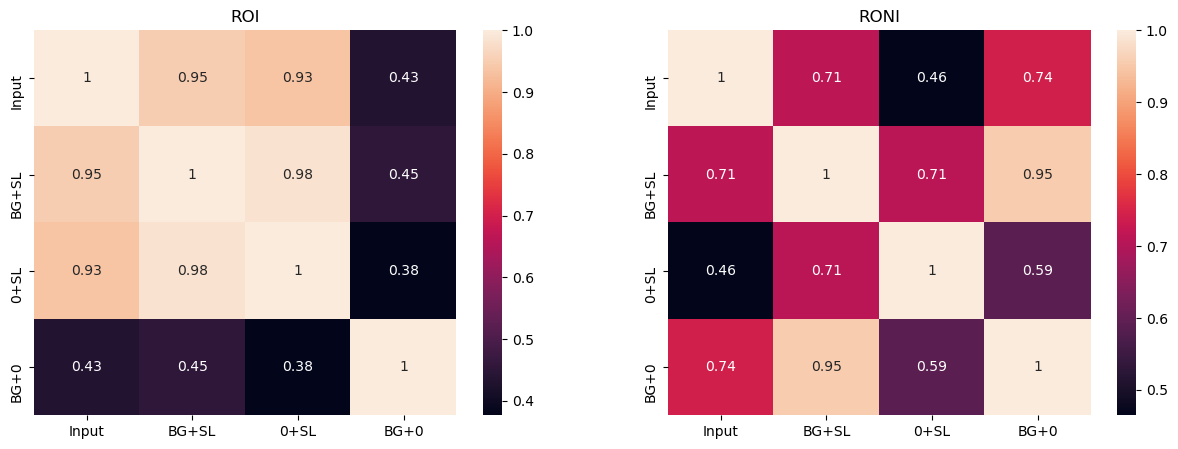

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.heatmap(np.array([(np.corrcoef(np.array((inputs_gm.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_tg.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_fg.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_bg.detach().cpu().numpy()[:,0,:][v,:])))) for v in range(inputs_gm.shape[0])]).mean(axis=0),annot=True,xticklabels=['Input','BG+SL','0+SL','BG+0'],
            yticklabels=['Input','BG+SL','0+SL','BG+0'])

plt.title('ROI')

plt.subplot(1,2,2)
sns.heatmap(np.array([(np.corrcoef(np.array((inputs_cf.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_tg.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_fg.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_bg.detach().cpu().numpy()[:,0,:][v,:])))) for v in range(inputs_gm.shape[0])]).mean(axis=0),annot=True,xticklabels=['Input','BG+SL','0+SL','BG+0'],
            yticklabels=['Input','BG+SL','0+SL','BG+0'])

plt.title('RONI')

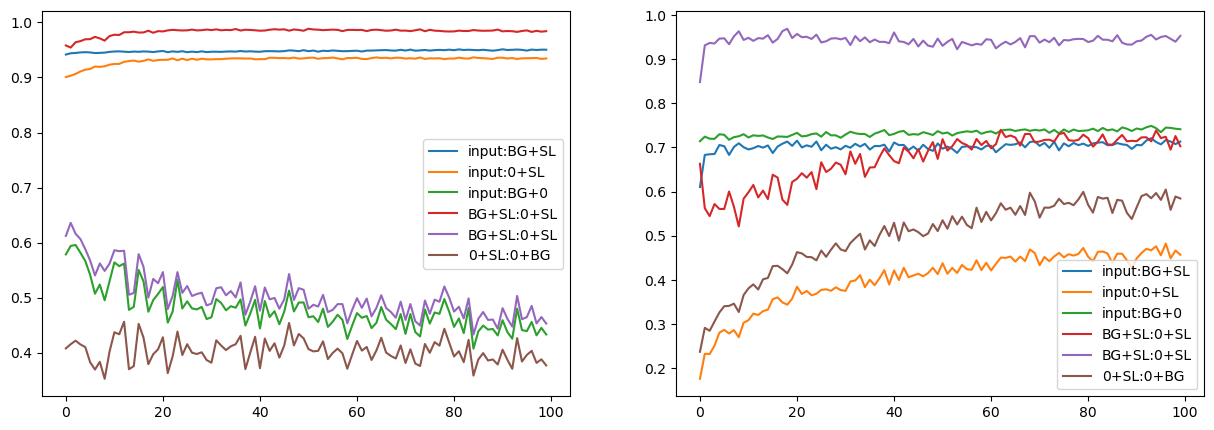

In [36]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(np.array(track['cmat_bg'])[:,0,1]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,0,2]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,0,3]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,1,2]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,1,3]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,2,3]))
plt.legend(['input:BG+SL', 'input:0+SL','input:BG+0','BG+SL:0+SL','BG+SL:0+SL','0+SL:0+BG'])

plt.subplot(1,2,2)
plt.plot(np.array(np.array(track['cmat_cf'])[:,0,1]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,0,2]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,0,3]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,1,2]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,1,3]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,2,3]))
plt.legend(['input:BG+SL', 'input:0+SL','input:BG+0','BG+SL:0+SL','BG+SL:0+SL','0+SL:0+BG'])

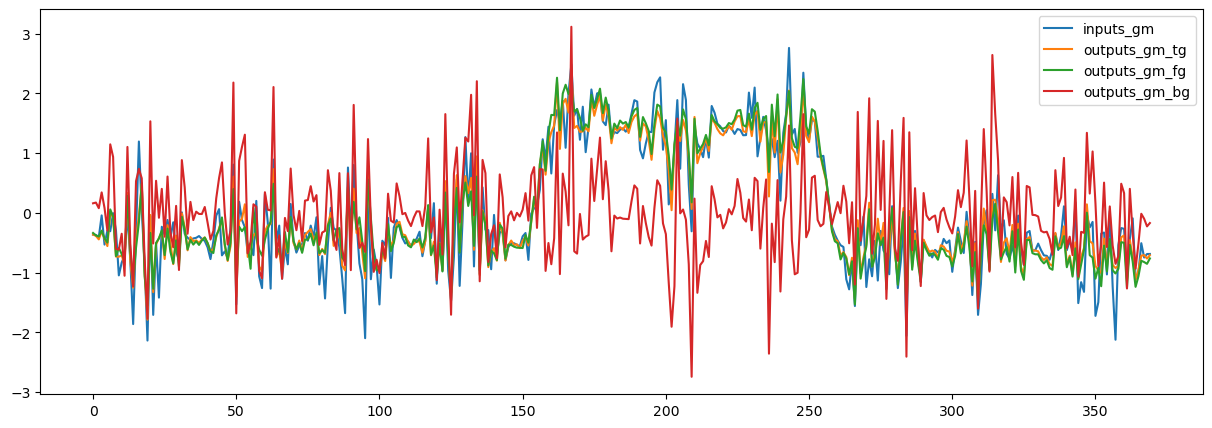

In [37]:
plt.figure(figsize=(15,5))
plt.plot( inputs_gm.detach().cpu().numpy()[:,0,:][0,:] )
plt.plot( outputs_gm_tg.detach().cpu().numpy()[:,0,:][0,:] )
plt.plot( outputs_gm_fg.detach().cpu().numpy()[:,0,:][0,:] )
plt.plot( outputs_gm_bg.detach().cpu().numpy()[:,0,:][0,:] )

plt.legend(['inputs_gm','outputs_gm_tg','outputs_gm_fg','outputs_gm_bg'])

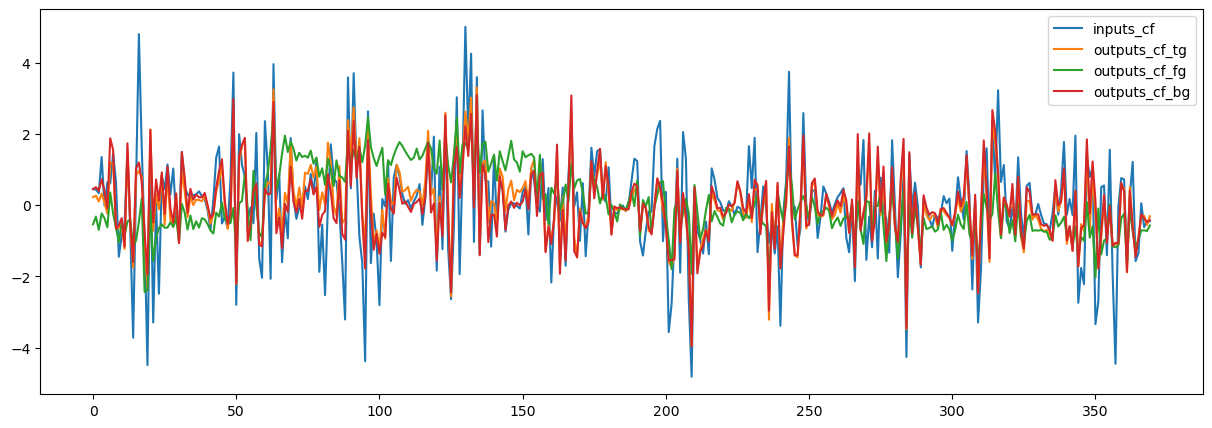

In [38]:
plt.figure(figsize=(15,5))
plt.plot( inputs_cf.detach().cpu().numpy()[:,0,:][0,:] )
plt.plot( outputs_cf_tg.detach().cpu().numpy()[:,0,:][0,:] )
plt.plot( outputs_cf_fg.detach().cpu().numpy()[:,0,:][0,:] )
plt.plot( outputs_cf_bg.detach().cpu().numpy()[:,0,:][0,:] )
plt.legend(['inputs_cf','outputs_cf_tg','outputs_cf_fg','outputs_cf_bg'])

In [39]:
np.array([np.corrcoef(inputs_gm.cpu().detach().numpy()[:,0,:][v,:],outputs_gm.cpu().detach().numpy()[:,0,:][v,:])[0,1] for v in range(batch_size)]).mean()

0.9500913272971611

In [40]:
np.array([np.corrcoef(inputs_cf.cpu().detach().numpy()[:,0,:][v,:],outputs_cf.cpu().detach().numpy()[:,0,:][v,:])[0,1] for v in range(batch_size)]).mean()

0.7396914697891219

Text(0.5, 1.0, 'running_TC_L: 0.0000')

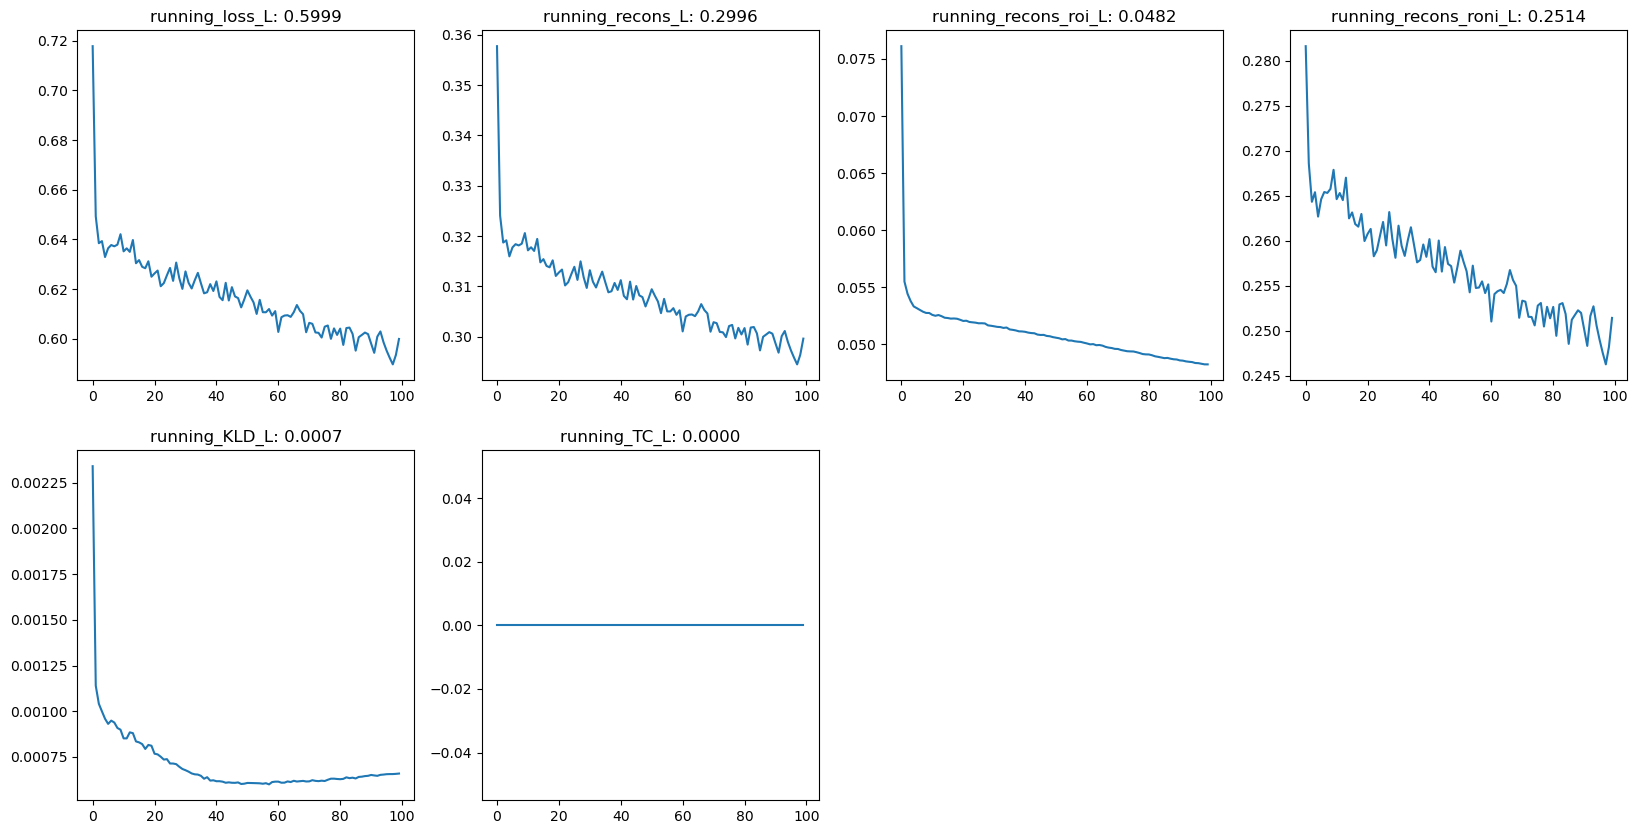

In [41]:
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.plot(running_loss_L);plt.title(f'running_loss_L: {running_loss_L[-1]:.4f}')

plt.subplot(2,4,2)
plt.plot(running_recons_L);plt.title(f'running_recons_L: {running_recons_L[-1]:.4f}')

plt.subplot(2,4,3)
plt.plot(running_recons_roi_L);plt.title(f'running_recons_roi_L: {running_recons_roi_L[-1]:.4f}')

plt.subplot(2,4,4)
plt.plot(running_recons_roni_L);plt.title(f'running_recons_roni_L: {running_recons_roni_L[-1]:.4f}')


plt.subplot(2,4,5)
plt.plot(running_KLD_L);plt.title(f'running_KLD_L: {running_KLD_L[-1]:.4f}')

plt.subplot(2,4,6)
plt.plot(running_TC_L);plt.title(f'running_TC_L: {running_TC_L[-1]:.4f}')

In [42]:
# plt.figure(figsize=(20,10))
# for i,key in enumerate(track.keys()):
#     plt.subplot(2,3,i+1)
#     plt.plot(track[key])
#     plt.title(key)

# plt.subplots_adjust()

In [43]:
# dataloader_iter_in = iter(train_in)
# inputs_gm,inputs_cf = next(dataloader_iter_in)
# inputs_gm = inputs_gm.unsqueeze(1).float().to(device)
# inputs_cf = inputs_cf.unsqueeze(1).float().to(device)
# [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(inputs_gm)
# [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(inputs_cf)

Text(0.5, 1.0, 'CF in/out: corr: 0.74')

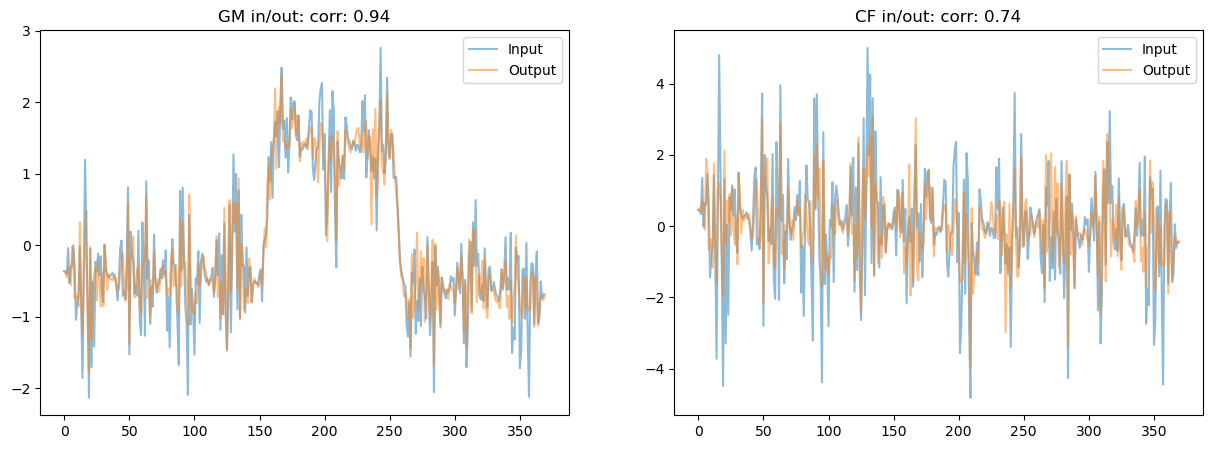

In [44]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
v1 = inputs_gm.detach().cpu().numpy()[0,0,:]
v2 = outputs_gm.detach().cpu().numpy()[0,0,:]

plt.plot(v1,alpha=.5)
plt.plot(v2,alpha=.5)
plt.title(f'GM in/out: corr: {np.corrcoef(v1,v2)[0,1]:.2f}')
plt.legend(['Input','Output'])

plt.subplot(1,2,2)
v1 = inputs_cf.detach().cpu().numpy()[0,0,:]
v2 = outputs_cf.detach().cpu().numpy()[0,0,:]

plt.plot(v1,alpha=.5)
plt.plot(v2,alpha=.5)
plt.legend(['Input','Output'])
plt.title(f'CF in/out: corr: {np.corrcoef(v1,v2)[0,1]:.2f}')

In [45]:
func_data = obs_list

denoise_inputs = DenoiseDataset(func_data)
denoise_in = torch.utils.data.DataLoader(denoise_inputs, batch_size=64,
                                              shuffle=False, num_workers=1)
denoise_iter_in = iter(denoise_in)
for i in tqdm(range(len(denoise_in))):
    inputs = next(denoise_iter_in)
    inputs = inputs.unsqueeze(1).float().to(device)
    func_output = model.generate(inputs)
    func_output_np = func_output.squeeze().cpu().detach().numpy()
    if i == 0:
        outputs_all = func_output_np 
    else:
        outputs_all = np.concatenate((outputs_all,func_output_np), axis = 0)

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 165.84it/s]


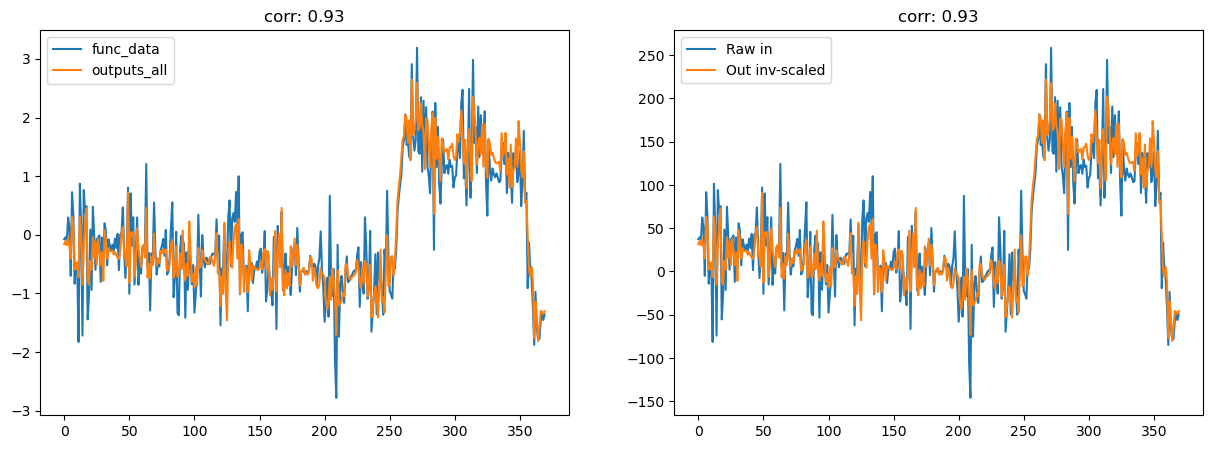

In [46]:
v = 500
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(func_data[v,:])
plt.plot(outputs_all[v,:])
plt.legend(['func_data','outputs_all'])
plt.title(f'corr: {np.corrcoef(func_data[v,:],outputs_all[v,:])[0,1]:.2f}')

plt.subplot(1,2,2)
plt.plot(func_gm[v,:])

descaled = obs_scale.inverse_transform(outputs_all)
if do_norm==True:
    descaled = obs_scale.inverse_transform(outputs_all * (max_obs_list-min_obs_list) + min_obs_list)
plt.plot(descaled[v,:])
plt.title(f'corr: {np.corrcoef(func_gm[v,:],descaled[v,:])[0,1]:.2f}')
plt.legend(['Raw in','Out inv-scaled'])

In [47]:
denoised_flat = np.zeros(epi_flat.shape)
#denoised_flat[gm_flat==1,:]=obs_scale.inverse_transform(outputs_all) # ORIG no work
#denoised_flat[gm_flat==1,:][~(epi_flat[gm_flat==1,:].std(axis=1)==0.0),:] = obs_scale.inverse_transform(outputs_all) # Takes into account std0 voxels

vec1 = gm_flat==1
vec2 = epi_flat.std(axis=1)!=0.0
vec3 = vec1*vec2
denoised_flat[vec3,:] = obs_scale.inverse_transform(outputs_all) # Takes into account std0 voxels
if do_norm==True:
    denoised_flat[vec3,:] = obs_scale.inverse_transform(outputs_all * (max_obs_list-min_obs_list) + min_obs_list) # Takes into account std0 voxels and denorm

#denoised_flat = denoised_flat+epi_flat.mean(axis=0) # Aesthetics
#denoised_mat = denoised_flat.transpose().reshape(epi.shape)
denoised_mat = denoised_flat.reshape(epi.shape)

denoised = epi.new_image_like(denoised_mat)
#ofn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-DEEPCOR_bold.nii'.format(sub=sub,r=r))
#denoised.to_filename(ofn)

ValueError: shape mismatch: value array of shape (10000,370) could not be broadcast to indexing result of shape (183909,370)

Text(0.5, 1.0, 'Voxel simililaryt')

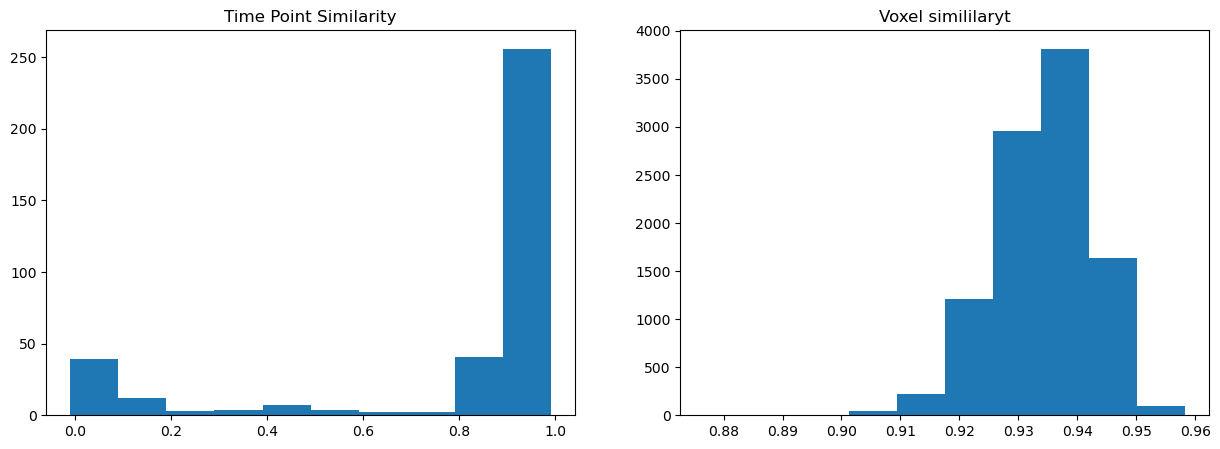

In [48]:
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.hist(correlate_columns(denoised_flat[ gm_flat==1,:],epi_flat[ gm_flat==1,:]))
# plt.title('Time Point Similarity')
# plt.subplot(1,2,2)
# plt.hist(correlate_columns(denoised_flat[ gm_flat==1,:].transpose(),epi_flat[ gm_flat==1,:].transpose()))
# plt.title('Voxel simililaryt')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(correlate_columns(func_gm,outputs_all))
plt.title('Time Point Similarity')
plt.subplot(1,2,2)
plt.hist(correlate_columns(func_gm.transpose(),outputs_all.transpose()))
plt.title('Voxel simililaryt')

In [49]:
pca = PCA(n_components=5)
comps = pca.fit_transform(func_cf.transpose())
lin_reg = linear_model.LinearRegression()
lin_reg.fit(comps,func_gm.transpose())
predicted = lin_reg.predict(comps)
residuals = func_gm-predicted.transpose()

Text(0.5, 1.0, 'Voxel simililaryt')

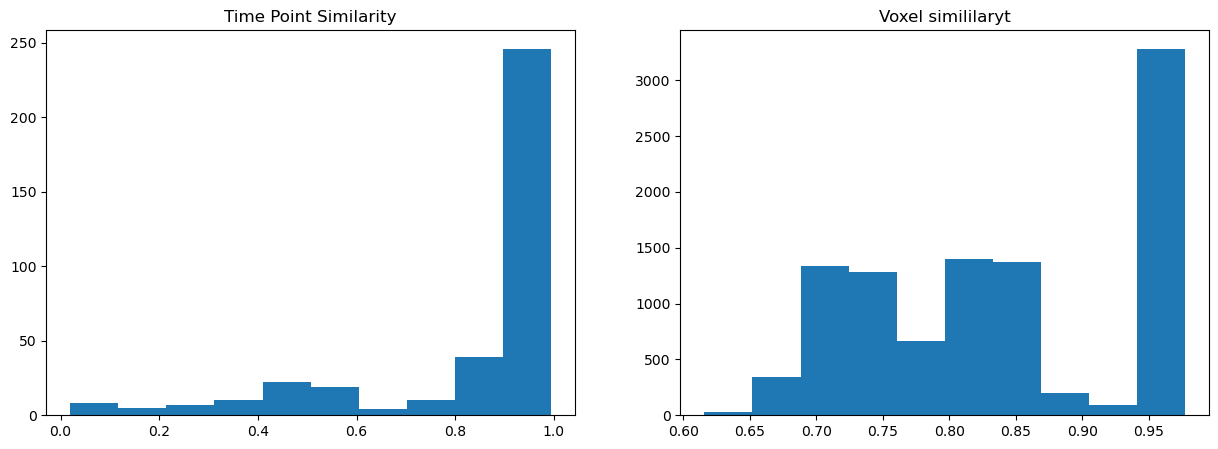

In [50]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(correlate_columns(residuals,func_gm))
plt.title('Time Point Similarity')
plt.subplot(1,2,2)
plt.hist(correlate_columns(func_gm.transpose(),residuals.transpose()))
plt.title('Voxel simililaryt')

In [51]:
SS_mean = ((func_gm-func_gm.mean(axis=0))**2).mean()
SS_deepcorr = ((func_gm-obs_scale.inverse_transform(outputs_all))**2).mean()
SS_compcorr = ((func_gm-func_gm.mean()-residuals)**2).mean()

In [52]:
# SS_mean = ((gound_truth*240-func_gm.mean(axis=0))**2).mean()
# SS_deepcorr = ((gound_truth*240-obs_scale.inverse_transform(outputs_all))**2).mean()
# SS_compcorr = ((gound_truth*240-residuals)**2).mean()

In [53]:
(SS_mean,SS_deepcorr,SS_compcorr)

(4411.916725955499, 684.8473214277765, 1606.6953176775764)

In [54]:
1-(SS_deepcorr/SS_mean)

0.8447732892602461

In [55]:
1-(SS_compcorr/SS_mean)

0.63582827657981

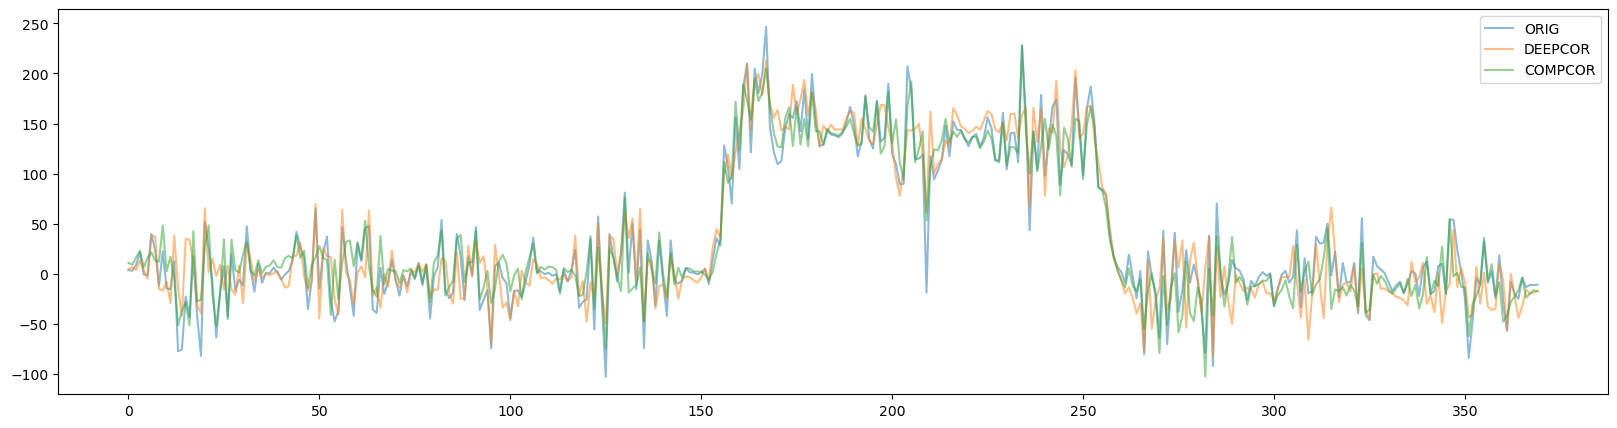

In [56]:
plt.figure(figsize=(20,5))
plt.plot(func_gm[0,:],alpha=.5)
plt.plot(obs_scale.inverse_transform(outputs_all)[0,:],alpha=.5)
plt.plot(residuals[0,:]+func_gm[0,:].mean(),alpha=.5)
#plt.plot((gound_truth*240)[0,:],alpha=.5)
plt.legend(['ORIG','DEEPCOR','COMPCOR'])

In [57]:
# Data-CompCorr corr
correlate_columns(func_gm.transpose(),residuals.transpose()).mean()

0.8375216182617915

In [58]:
# Data-DeepCor corr
correlate_columns(func_gm.transpose(),obs_scale.inverse_transform(outputs_all).transpose()).mean()

0.9342394097355043

In [59]:
# CompCor-DeepCor corr
correlate_columns(obs_scale.inverse_transform(outputs_all).transpose(),residuals.transpose()).mean()

0.7963959487535068